In [163]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders

In [2]:
from pmdarima import auto_arima # for determining ARIMA orders

### Viewing first df

In [96]:
df1 = pd.read_csv('../data/POP.csv')

In [97]:
df1.head()

,realtime_start,value,date,realtime_end
0,2019-12-06,156309.0,1952-01-01,2019-12-06
1,2019-12-06,156527.0,1952-02-01,2019-12-06
2,2019-12-06,156731.0,1952-03-01,2019-12-06
3,2019-12-06,156943.0,1952-04-01,2019-12-06
4,2019-12-06,157140.0,1952-05-01,2019-12-06


the date column within the first dataframe has a monthly frequency ('MS' freq to be specific)

In [98]:
df1['date'].max()

'2019-12-01'

In [99]:
df1['date'] = pd.to_datetime(df1['date'])

In [100]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 816 entries, 0 to 815
Data columns (total 4 columns):
realtime_start    816 non-null object
value             816 non-null float64
date              816 non-null datetime64[ns]
realtime_end      816 non-null object
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 25.6+ KB


In [101]:
df1.set_index('date', inplace=True)
df1.index.freq = 'MS'

In [102]:
df1.index

DatetimeIndex(['1952-01-01', '1952-02-01', '1952-03-01', '1952-04-01',
               '1952-05-01', '1952-06-01', '1952-07-01', '1952-08-01',
               '1952-09-01', '1952-10-01',
               ...
               '2019-03-01', '2019-04-01', '2019-05-01', '2019-06-01',
               '2019-07-01', '2019-08-01', '2019-09-01', '2019-10-01',
               '2019-11-01', '2019-12-01'],
              dtype='datetime64[ns]', name='date', length=816, freq='MS')

In [103]:
df1['value'] = df1['value'].apply(lambda x: x*1000)

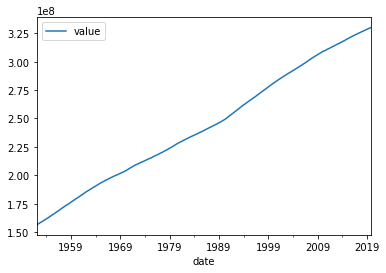

In [104]:
df1.plot()

### Viewing second df

In [105]:
df2 = pd.read_csv('../data/POPH.csv')

In [106]:
df2.tail()

,realtime_start,value,date,realtime_end
95,2019-12-06,262803276,1995-01-01,2019-12-06
96,2019-12-06,265228572,1996-01-01,2019-12-06
97,2019-12-06,267783607,1997-01-01,2019-12-06
98,2019-12-06,270248003,1998-01-01,2019-12-06
99,2019-12-06,272690813,1999-01-01,2019-12-06


It seems that the date column within our second dataframe has a yearly frequency

In [107]:
df2['date'] = pd.to_datetime(df2['date'])

In [108]:
df2.set_index('date', inplace=True)
df2.index.freq = 'AS'

In [109]:
df2 = df2.resample('MS').ffill()

In [110]:
df2 = df2.loc[:'1951-12-01']

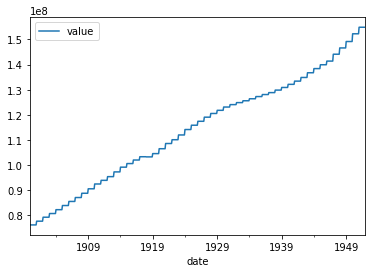

In [111]:
df2.plot()

### Merging dfs

In [117]:
pop_df = df2.reset_index().merge(df1.reset_index(), how = 'outer').set_index('date')

In [124]:
pop_df.isna().sum()

realtime_start    0
value             0
realtime_end      0
dtype: int64

In [118]:
pop_df.index

DatetimeIndex(['1900-01-01', '1900-02-01', '1900-03-01', '1900-04-01',
               '1900-05-01', '1900-06-01', '1900-07-01', '1900-08-01',
               '1900-09-01', '1900-10-01',
               ...
               '2019-03-01', '2019-04-01', '2019-05-01', '2019-06-01',
               '2019-07-01', '2019-08-01', '2019-09-01', '2019-10-01',
               '2019-11-01', '2019-12-01'],
              dtype='datetime64[ns]', name='date', length=1440, freq=None)

In [119]:
pop_df.index.freq = 'MS'

In [120]:
pop_df.head()

,realtime_start,value,realtime_end
date,,,
1900-01-01,2019-12-06,76094000.0,2019-12-06
1900-02-01,2019-12-06,76094000.0,2019-12-06
1900-03-01,2019-12-06,76094000.0,2019-12-06
1900-04-01,2019-12-06,76094000.0,2019-12-06
1900-05-01,2019-12-06,76094000.0,2019-12-06


We don't need the realtime start and realtime end columns, so we will drop these from our dataframe

In [125]:
pop_df.drop(columns=['realtime_start', 'realtime_end'], inplace=True)

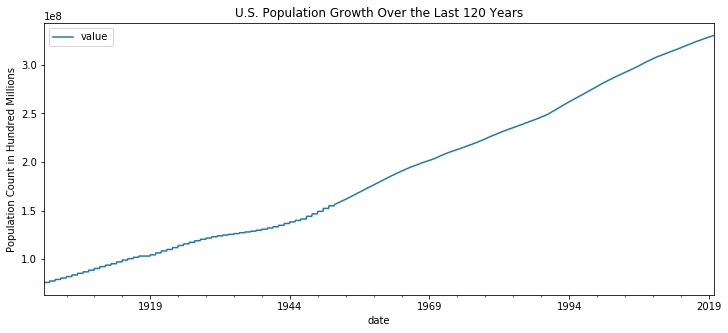

In [132]:
ax = pop_df.plot(figsize=(12,5))
ax.set_ylabel('Population Count in Hundred Millions')
ax.set_title('U.S. Population Growth Over the Last 120 Years');

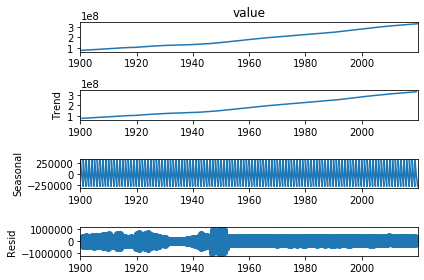

In [162]:
seasonal = seasonal_decompose(pop_df['value'], model='add')
seasonal.plot();

In [145]:
def adfuller_report(series):
    
    values = adfuller(series.dropna(), autolag='AIC')
    tags = ['Test Statistic', 'P-value', 'Used_lag', 'num_obs']
    
    output = pd.Series(values[0:4],index=tags)
    
    if output['P-value'] <= 0.05:
        print('Reject the null hypothesis. \nSeries is stationary.')
    else:
        print('Failed to reject null hypothesis. \nSeries is non-stationary.') 

In [146]:
test = adfuller_report(pop_df['value'])

Failed to reject null hypothesis. 
Series is non-stationary.


In [159]:
auto_arima(pop_df['value'], seasonal=True, m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 1440
Model:             SARIMAX(1, 2, 0)x(2, 0, 0, 12)   Log Likelihood              -20620.907
Date:                            Wed, 17 Mar 2021   AIC                          41249.815
Time:                                    18:50:03   BIC                          41270.899
Sample:                                         0   HQIC                         41257.686
                                           - 1440                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0200      0.001    -16.057      0.000      -0.022      -0.018
ar.S.L12       0.0376      0.001     42.498      0.000       0.036       0.039
ar.S.L24       0.0389      0.001     41.006      0.000       0.037       0.041
sigma2      1.457e+11   5.55e-17   2.63e+27      0.000    1.46e+11    1.46e+11
===================================================================================
Ljung-Box (L1) (Q):                 339.14   Jarque-Bera (JB):             18271.72
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.00   Skew:                             0.10
Prob(H) (two-sided):                  0.00   Kurtosis:                        20.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.97e+41. Standard errors may be unstable.
"""

### Splitting into train and test sets

In [ ]:
model = SARIMAX(order=(1,2,0), seasonal_order=(2,0,0,12))